In [213]:
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### 데이터 불러오기

In [214]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path) # 폴더 만드는 코드
    

transform = transforms.Compose([transforms.ToTensor()])

trn_dset = datasets.CIFAR100(root=data_path, train=True, transform=transform, download=True)
tst_dset = datasets.CIFAR100(root=data_path, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


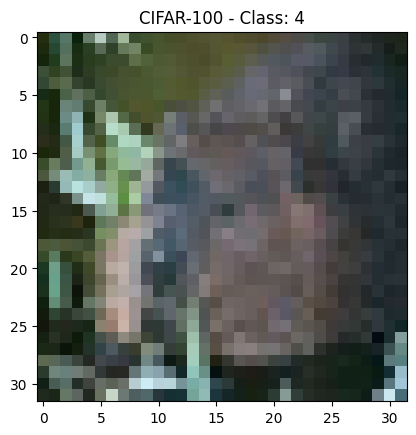

In [215]:
random_index = np.random.randint(0, len(trn_dset))
image, label = trn_dset[random_index]

# 이미지 시각화
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title(f"CIFAR-100 - Class: {label}")
plt.show()

In [216]:
print("Number of classes:", len(trn_dset.classes))
print("Number of training samples:", len(trn_dset))
print("Number of test samples:", len(tst_dset))
print("Shape of each image:", trn_dset[0][0].shape)

Number of classes: 100
Number of training samples: 50000
Number of test samples: 10000
Shape of each image: torch.Size([3, 32, 32])


In [217]:
trn_dset.classes[23]

'cloud'

## 모델 아키텍처(VGG-16)
- 16개의 레이어
- 모든 conv net은 kernel_size=3x3, stride=1, padding=1로 고정
- 활성화 함수는 ReLU 사용
- 풀링은 maxpooling


    인풋 -> conv(윈도우 개수 64) -> conv(64) -> pooling -> conv(128) -> conv(128) -> 
    polling -> conv(256) -> conv(256) -> pooling -> conv(512) -> conv(512) ->
    conv(512) -> pooling -> conv(512) -> conv(512) -> conv(512) -> pooling ->
    fc layer(채널 4096) -> fc layer(4096) -> fc layer(1000) -> softmax

### conv layer 두 개 있는 블록

In [218]:
def conv_2_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1, stride=1), # stride는 default값이므로 생략 가능
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),  # 이전 레이어의 출력 결과를 인풋으로
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

### conv layer 세 개 있는 블록

In [219]:
def conv_3_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    
    return model

In [227]:
64*8*7*7

25088

In [220]:
class VGG(nn.Module):
    def __init__(self, base_dim=64, num_class=1000):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            conv_2_block(3,base_dim), # RGB 세 컬러이므로 첫 채널은 3 이를 base_dim으로  
            conv_2_block(base_dim,base_dim*2), # 3, 64
            conv_3_block(base_dim*2,base_dim*4), # 64, 256
            conv_3_block(base_dim*4,base_dim*8), # 256, 512
            conv_3_block(base_dim*8,base_dim*8), # 512, 512
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(base_dim*8*7*7, 4096), # in_features, out_features, 1*1 : 피처맵의 높너비, 512는 피처맵의 채널 수 
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,num_class),
        )

        
    def forward(self, x):
        x = self.features(x)
        # 컨볼루션 -> fc로 넘어갈 때는 텐서의 모양을 조정해주어야 함 (2차원 -> 1차원)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool1 = nn.MaxPool2d(2,2) 
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) # conv1 -> ReLU -> pool1
        x = self.pool2(F.relu(self.conv2(x))) # conv2 -> ReLU -> pool2

        x = x.view(-1, 16 * 5 * 5) # 5x5 피쳐맵 16개를 일렬로 만든다.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

In [221]:
### DataLoader 생성
trn_loader = DataLoader(dataset=trn_dset,
                       batch_size=100,
                         drop_last=False
                       )
tst_loader = DataLoader(dataset=tst_dset, 
                         batch_size=100,
                         shuffle=False,
                         drop_last=False)

In [222]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 객체 생성

In [223]:
model = VGG().to(device)

In [224]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

## pretrained model weights 사용하기

In [198]:
from torchvision.models import vgg16, VGG16_Weights

# Step 1: Initialize model with the best available weights
weights = VGG16_Weights.DEFAULT
pre_model = vgg16(weights=weights)

In [199]:
model.state_dict()

OrderedDict([('features.0.0.weight',
              tensor([[[[-1.8776e-01,  1.4926e-01,  1.0416e-01],
                        [-1.3251e-03,  1.2687e-01,  1.5807e-01],
                        [ 1.7910e-01,  7.2496e-02,  9.1343e-02]],
              
                       [[ 1.8690e-01,  1.4670e-01, -1.8055e-01],
                        [ 1.2872e-02,  2.6420e-02,  8.2731e-02],
                        [-2.8129e-04, -8.4732e-02, -2.8419e-02]],
              
                       [[-5.6981e-02,  2.6940e-02, -1.2277e-01],
                        [-1.1491e-01, -4.0371e-02, -1.4858e-01],
                        [ 7.4462e-02, -1.8859e-01,  5.7685e-02]]],
              
              
                      [[[-7.7638e-02, -1.4274e-01,  1.2310e-01],
                        [-1.3781e-01, -1.2613e-01, -4.9238e-02],
                        [-2.1893e-02, -1.6260e-01, -1.0712e-01]],
              
                       [[ 1.2507e-01,  9.7527e-02,  2.7336e-02],
                        [-7.1457e-02, 

In [200]:
w_map = {'features.0.0.weight':'features.0.weight', 'features.0.0.bias':'features.0.bias',
         'features.0.2.weight':'features.2.weight', 'features.0.2.bias':'features.2.bias',
         'features.1.0.weight':'features.5.weight', 'features.1.0.bias':'features.5.bias',
         'features.1.2.weight':'features.7.weight', 'features.1.2.bias':'features.7.bias',
         'features.2.0.weight':'features.10.weight', 'features.2.0.bias':'features.10.bias',
         'features.2.2.weight':'features.12.weight', 'features.2.2.bias':'features.12.bias',
         'features.2.4.weight':'features.14.weight', 'features.2.4.bias':'features.14.bias',
         'features.3.0.weight':'features.17.weight', 'features.3.0.bias':'features.17.bias',
         'features.3.2.weight':'features.19.weight', 'features.3.2.bias':'features.19.bias',
         'features.3.4.weight':'features.21.weight', 'features.3.4.bias':'features.21.bias',
         'features.4.0.weight':'features.24.weight','features.4.0.bias':'features.24.bias',
         'features.4.2.weight':'features.26.weight', 'features.4.2.bias':'features.26.bias',
         'features.4.4.weight':'features.28.weight', 'features.4.4.bias':'features.28.bias',
         'classifier.0.weight':'classifier.0.weight', 'classifier.0.bias':'classifier.0.bias',
         'classifier.3.weight':'classifier.3.weight', 'classifier.3.bias':'classifier.3.bias',
         'classifier.6.weight':'classifier.6.weight', 'classifier.6.bias':'classifier.6.bias'
        }

In [201]:
w_map = {v:i for i,v in w_map.items()}

In [202]:
new_dict = {w_map[key]: pre_model.state_dict()[f'{key}'] for key in w_map}

In [203]:
new_dict

{'features.0.0.weight': tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
           [-5.8312e-01,  3.5655e-01,  7.6566e-01],
           [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
 
          [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
           [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
           [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
 
          [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
           [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
           [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
 
 
         [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
           [-4.2805e-01, -2.4349e-01,  2.4628e-01],
           [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
 
          [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
           [-8.4127e-01, -3.5176e-01,  5.6398e-01],
           [-2.4194e-01,  5.1928e-01,  5.3915e-01]],
 
          [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
           [-4.7144e-01, -1.5503e-01,  3.4589e-01],
           [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],
 
 
         [[[ 1.77

In [204]:
# 기존 모델에 pre_trained model weights 업데이트
model.load_state_dict(new_dict)
model.state_dict()

OrderedDict([('features.0.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, 

In [205]:
# 모델 구조 저장
torch.save(model, 'VGG_model.pth')

In [206]:
model.classifier[0] = nn.Linear(512, 4096)
model.classifier[3] = nn.Linear(4096, 1000)
model.classifier[6] = nn.Linear(1000, 100)

### 평가

In [162]:
# 학습
# loss_arr = []

# for i in range (epoch):
#     for j, [image, label] in enumerate(trn_loader):
#         x = image.to(device)
#         y = label.to(device)
        
#         optimizer.zero_grad()
#         output = model.forward(x)
#         loss = loss_func(output, y)
#         loss.backward()
#         optimizer.step()
        
#     if i % 10 ==0:
#         print(loss)
#         loss_arr.append(loss.cpu().detach().numpy())

In [208]:
# 평가
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in tst_loader:
        # 이미지와 라벨 모두 디바이스에 올리고
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        _,output_index = torch.max(output,1)

        
        # 전체 개수 += 라벨의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()
    
    # 정확도 도출
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 1.090000033378601%


## Save Model

In [327]:
torch.save(model.state_dict(), 'VGG.pth')

In [328]:
model.load_state_dict(torch.load('VGG.pth'))

<All keys matched successfully>